# Lens Modeling of DESIJ1501+5208 with Lenstronomy


Author: Mamun Hossain Nahid,  Anowar Shajib \
Acknowledgement: Robin, Tanjela, Nushrat, Imtiaz.

## Import of standard python libraries

In [6]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from google.colab import drive
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, param_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

drive.mount("/content/drive")

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Imaging Data

In [7]:
with h5py.File("DESIJ1501+5208_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

In [8]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

### Visualizing the Data

<ipython-input-9-357dad159cb2>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


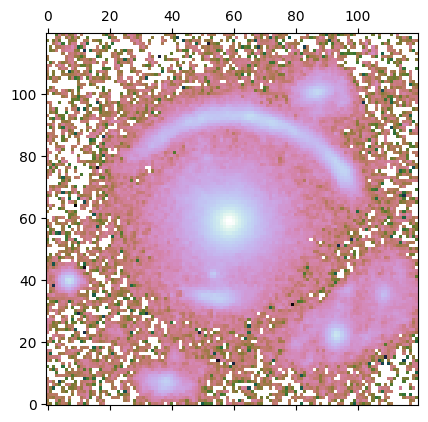

In [9]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

## Creating Mask

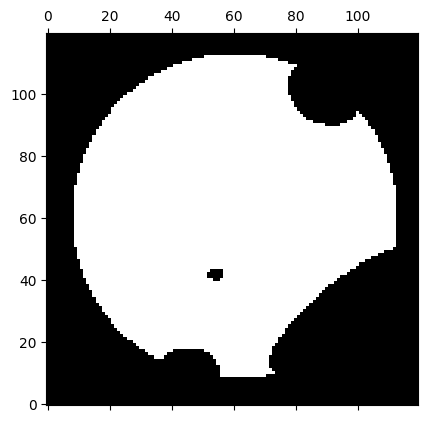

<ipython-input-10-d14db875bb19>:84: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
<ipython-input-10-d14db875bb19>:84: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


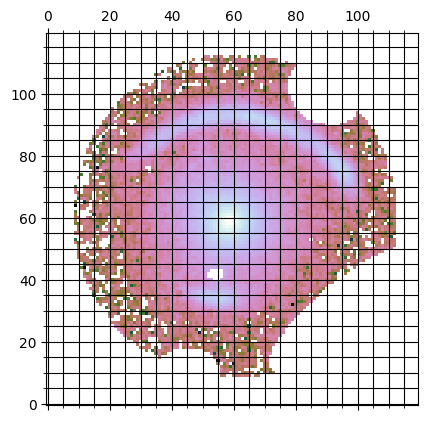

In [10]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 4.2  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# for the galaxy at 1 o clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 3.2,
    1.0,
    0.8,
    np.pi / 0.85,
)


# for the galaxy at 5 o clock
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.4,
    2.5,
    0.76,
    np.pi / 0.56,
)


# for the galaxy at 7 o clock
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.2,
    lens_center_dec - 4.0,
    0.8,
    0.6,
    0,
)

# for the galaxy at center
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.5,
    lens_center_dec - 1.5,
    0.2,
    0.15,
    0,
)

mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0
mask = mask.reshape(num_pix, num_pix)
plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# applying the mask
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Lens Modeling with Lenstronomy

In [11]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass Model for the Lens Galaxy

In [12]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

EPL Parameters


In [13]:
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": -0.0,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)


Shear Parameters

In [14]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.1, "gamma2": 0.0, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

### Light Model for the Source Galaxy

In [15]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

Sersic Ellipse Parameters

In [16]:
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.05,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


Shapelets Parameters

In [17]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.04, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.001, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.08, "center_x": 10, "center_y": 10})

### Light Model for the Lens Galaxy

In [18]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

1st Sersic Ellipse Parameters

In [19]:
fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5767,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

2nd Sersic Ellipse Parameters

In [20]:
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Combining Source and Lens Models

In [21]:
joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

## Numerical Settings

In [22]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

Combining All the Information to be Sent to Lenstronomy

In [23]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## PSO: Model Fitting

In [24]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.8448331496063036 reduced X^2 of best position
-3185.443390590568 log likelihood
7541 effective number of data points
[{'theta_E': 2.618391683174906, 'gamma': 1.8677568305192311, 'e1': 0.06314916498691528, 'e2': -0.007982234239349684, 'center_x': 0.038834548261965564, 'center_y': -0.30444810807029216}, {'gamma1': 0.11854347828250254, 'gamma2': 0.016109919794523954, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.11787637867102999, 'n_sersic': 1.0, 'e1': 0.036302194623342644, 'e2': 0.0322727830118136, 'center_x': -0.0779175666492012, 'center_y': 0.17009288909842443}, {'amp': 1, 'n_max': 8, 'beta': 0.05295867355121474, 'center_x': -0.0779175666492012, 'center_y': 0.17009288909842443}] source result
[{'amp': 1, 'R_sersic': 0.14881443308947437, 'n_sersic': 1.0, 'e1': 0.014993513362098615, 'e2': 0.02031451029003783, 'center_x': 0.14309608949173833, 'c

Save the Best Fit Parameters (PSO)





In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1501+5208_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

##PSO: Visualizing the fitted model

In [ ]:
### load saved best fit parameters ###

load_output_path = "DESIJ1501+5208_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

-0.837283055215789 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8372830552157854


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-24-12d54f11901b>:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


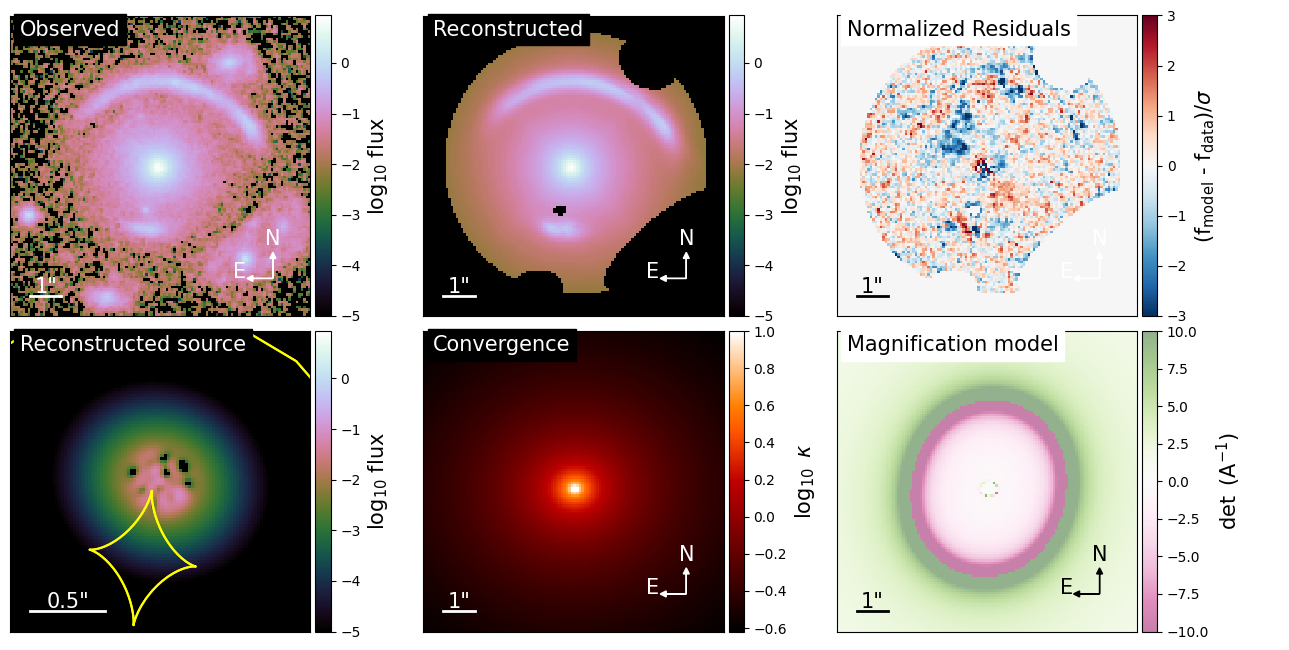

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


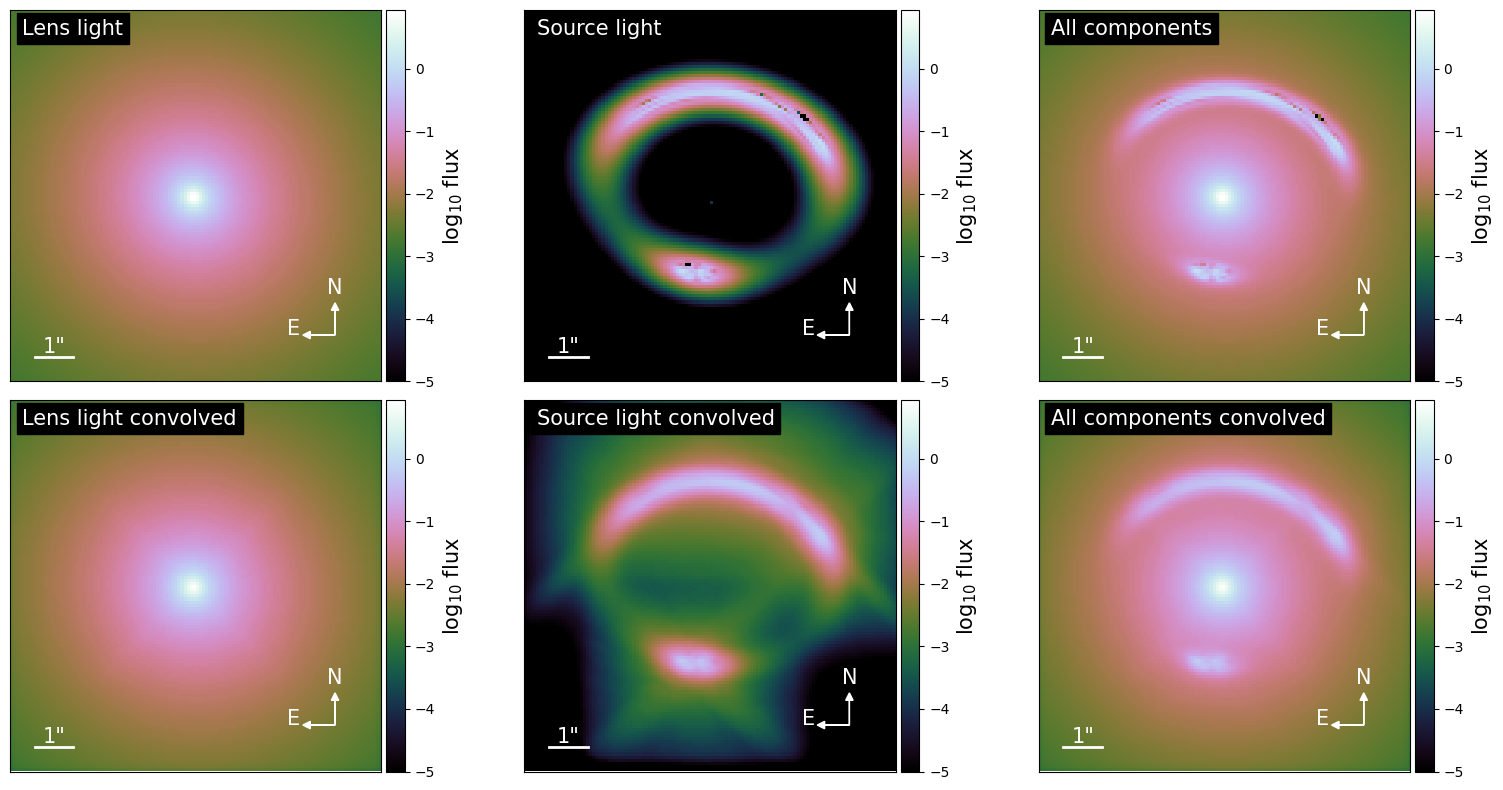

{'kwargs_lens': [{'theta_E': 2.618391683174906, 'gamma': 1.8677568305192311, 'e1': 0.06314916498691528, 'e2': -0.007982234239349684, 'center_x': 0.038834548261965564, 'center_y': -0.30444810807029216}, {'gamma1': 0.11854347828250254, 'gamma2': 0.016109919794523954, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 99.53809657644317, 'R_sersic': 0.11787637867102999, 'n_sersic': 1.0, 'e1': 0.036302194623342644, 'e2': 0.0322727830118136, 'center_x': -0.0779175666492012, 'center_y': 0.17009288909842443}, {'amp': array([-547.04652178,   58.18514738,  -31.33036988,  -24.74228404,
         85.69572209,  -10.67462834,  -40.50668089,  -67.1378716 ,
        -27.72784541,  -54.01934615,  -47.75432881,   28.08576915,
         23.43349881,   44.46975377,  -17.53566658,   20.03758505,
        -49.01131767,  -55.80524396,  -39.65366988,  -37.17574413,
        -51.39289961,  -25.06280782,   67.28008526,   34.15235458,
         14.32847973,   16.93126453,   39.37289779,    4.60024426,
         13.9157

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")


model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## MCMC: Model Fitting

In [26]:
# Define the path to the file on Google Drive
mcmc_backend = "mcmc_backend.h5"


fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 5,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]


chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|██████████| 5/5 [06:11<00:00, 74.29s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 5
376.4743502140045 time taken for MCMC sampling


### Trace Plots

In [27]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (677000, 20)



<ipython-input-28-b288d22036c9>:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 3385, N_walkers: 200, N_params: 20
theta_E_lens0 2.6034 ± 0.0034
gamma_lens0 2.0845 ± 0.0286
e1_lens0 0.0915 ± 0.0145
e2_lens0 -0.0124 ± 0.0057
center_x_lens0 0.0328 ± 0.0072
center_y_lens0 -0.3477 ± 0.0204
gamma1_lens1 0.1450 ± 0.0077
gamma2_lens1 0.0263 ± 0.0037
R_sersic_source_light0 0.1307 ± 0.0043
e1_source_light0 0.0386 ± 0.0184
e2_source_light0 0.0000 ± 0.0175
center_x_source_light0 -0.0946 ± 0.0062
center_y_source_light0 0.2814 ± 0.0228
beta_source_light1 0.0792 ± 0.0013
R_sersic_lens_light0 0.1486 ± 0.0032
e1_lens_light0 0.0144 ± 0.0028
e2_lens_light0 0.0195 ± 0.0023
center_x_lens_light0 0.1433 ± 0.0008
center_y_lens_light0 -0.1376 ± 0.0008
R_sersic_lens_light1 1.0985 ± 0.0216


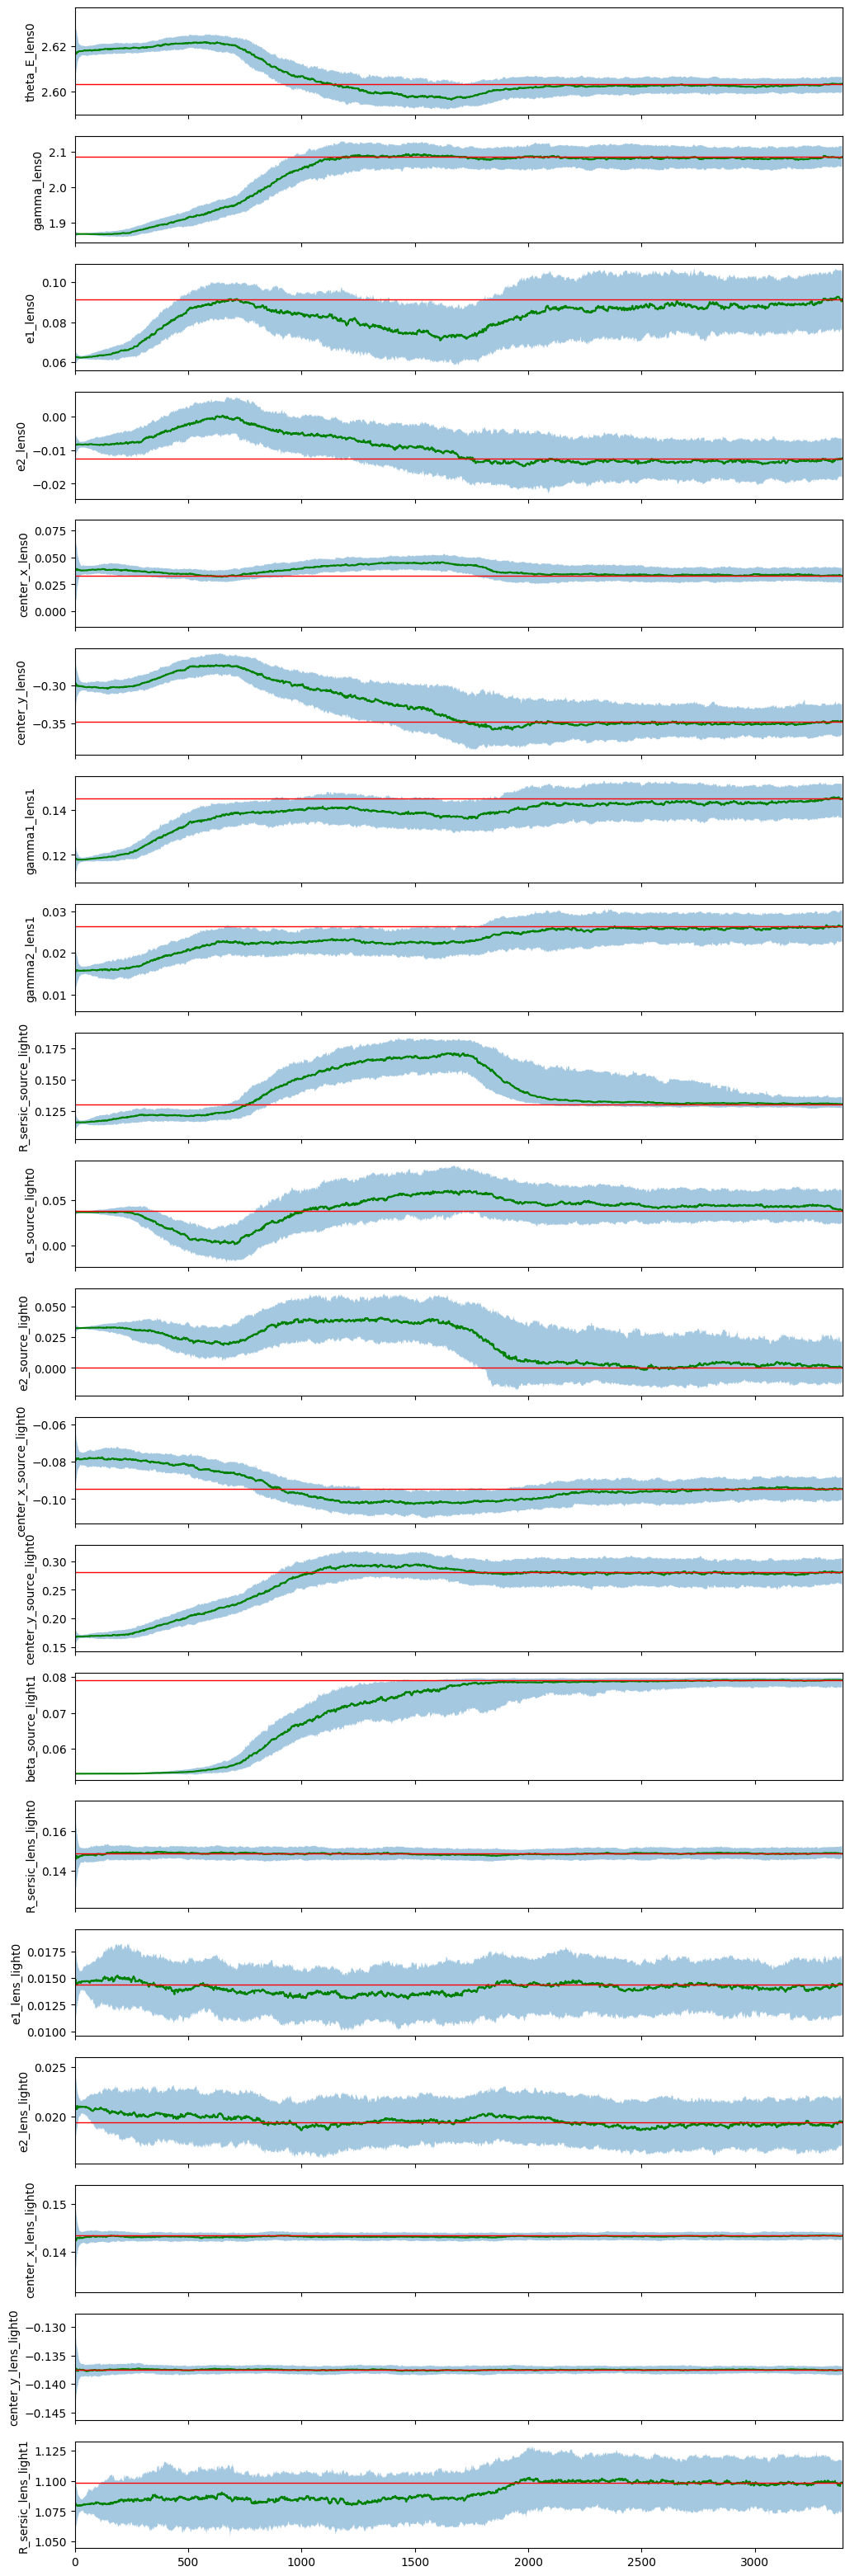

In [28]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

### Corner Plots

In [30]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2900
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

Output hidden; open in https://colab.research.google.com to view.

## MCMC: Visualizing the Fitted Model

-0.8251190322490002 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8251190322488855


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-31-628449185b14>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


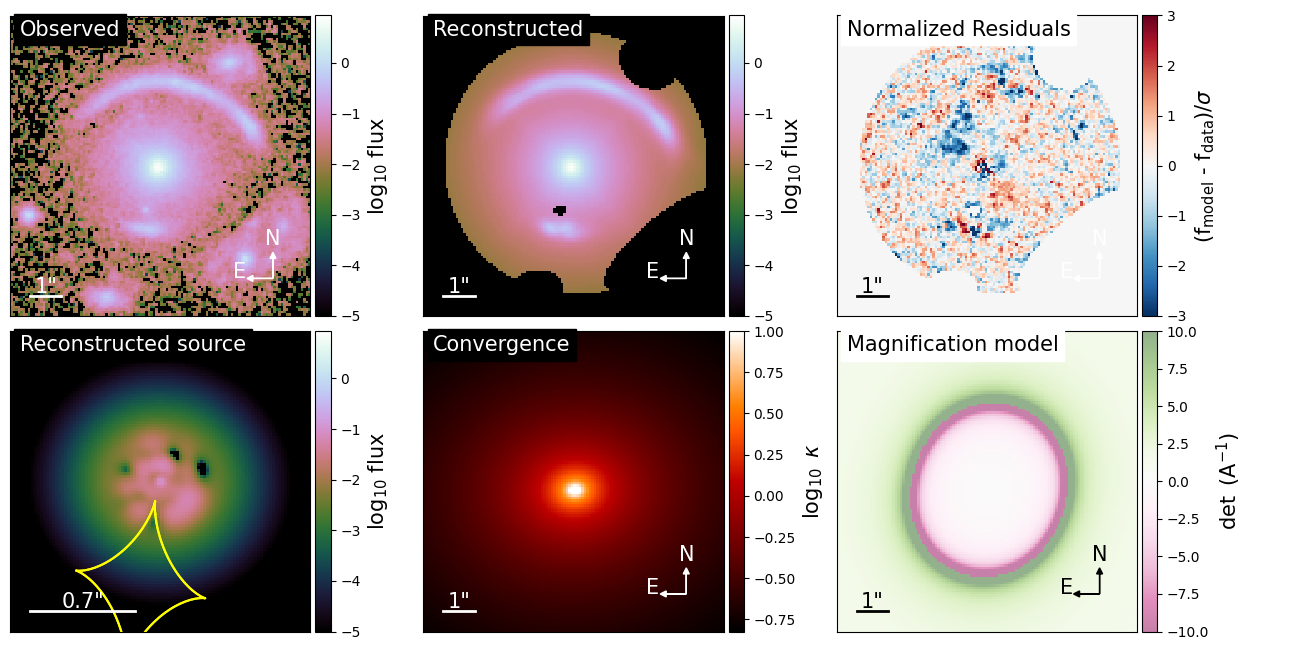

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


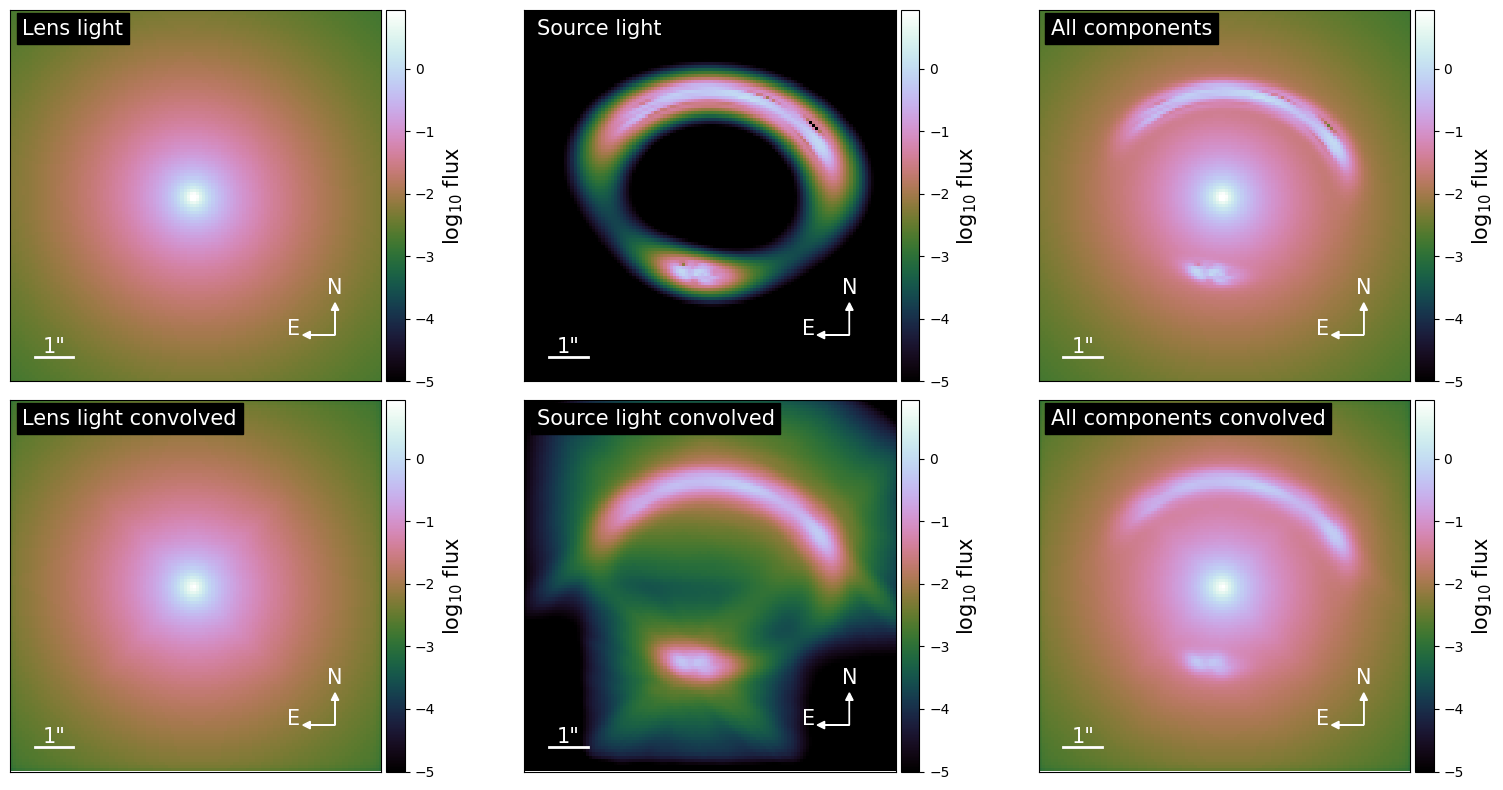

{'kwargs_lens': [{'theta_E': 2.602423164232407, 'gamma': 2.0928545287414932, 'e1': 0.09569648836685281, 'e2': -0.013818608346117159, 'center_x': 0.03305666976755785, 'center_y': -0.3484548756599077}, {'gamma1': 0.14762907074129888, 'gamma2': 0.026720082008710882, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 201.27029327001992, 'R_sersic': 0.13301291735380247, 'n_sersic': 1.0, 'e1': 0.030672635292033387, 'e2': 0.006671030506393566, 'center_x': -0.09326629465777755, 'center_y': 0.28581745599726815}, {'amp': array([-1.02362265e+03,  6.93079910e-02,  2.97367018e+01, -9.98313589e+00,
        5.57996303e+01,  6.23552374e+01, -2.26047616e+01, -8.10729838e+01,
       -2.81399562e+01, -7.85898886e+00, -6.13277393e+01,  6.01322152e+01,
       -3.19315162e+01,  5.50404306e+01, -8.57999223e+01, -3.23728966e+01,
       -5.34038366e+01, -4.95226109e+01, -7.24801217e+01, -1.27218322e+01,
       -4.18900692e+01, -7.80925340e+00,  5.15044287e+00,  3.77677711e+01,
        1.35805799e+01,  5.144360

In [31]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy

In [32]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.8236709898326833,
light_q: 0.9537576320842209


Save the Best Fit Parameters (MCMC)

In [33]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 3285
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "DESIJ1501+5208_mcmc_output.joblib"


with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 677000
677000
Shape of shortened_samples_mcmc: (1000, 20)


### Make dictionary of environment_params from the sigma_10 notebook

### Parameters withour Conversion

In [34]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [2.60311122491745, 0.0031106483386866834, 0.003695443143828303], 'gamma_lens0': [2.083668899427006, 0.02954313270701414, 0.02798070831466548], 'center_x_lens0': [0.033130305488043604, 0.007384661707673372, 0.006157518127173991], 'center_y_lens0': [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092], 'center_x_lens_light0': [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784], 'center_y_lens_light0': [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254]}


### Parameters with Conversion

In [35]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "gamma_shear",
    "phi_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [2.60311122491745, 0.0031106483386866834, 0.003695443143828303], 'gamma_lens0': [2.083668899427006, 0.02954313270701414, 0.02798070831466548], 'center_x_lens0': [0.033130305488043604, 0.007384661707673372, 0.006157518127173991], 'center_y_lens0': [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092], 'center_x_lens_light0': [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784], 'center_y_lens_light0': [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254], 'phi_mass': [-0.07062089119783126, 0.037553713585279924, 0.04068001166678517], 'q_mass': [0.8312134148128869, 0.02347224787051072, 0.022193904176616375], 'gamma_shear': [0.08959315646736743, 0.008541760945411647, 0.010914588338414091], 'phi_shear': [0.1474132813237036, 0.007024418601559668, 0.008842644855025089], 'phi_light': [0.46842463940573453, 0.06289781186294596, 0.059081412846965775], 'q_light': [0.9533601976138689, 0.004394183889137704, 0.004648692142942057]}


### Half light radius calculation

In [36]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius
print("\n", parameter_values)

Half-light radius: 0.7205276678934682

 {'theta_E_lens0': [2.60311122491745, 0.0031106483386866834, 0.003695443143828303], 'gamma_lens0': [2.083668899427006, 0.02954313270701414, 0.02798070831466548], 'center_x_lens0': [0.033130305488043604, 0.007384661707673372, 0.006157518127173991], 'center_y_lens0': [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092], 'center_x_lens_light0': [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784], 'center_y_lens_light0': [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254], 'phi_mass': [-0.07062089119783126, 0.037553713585279924, 0.04068001166678517], 'q_mass': [0.8312134148128869, 0.02347224787051072, 0.022193904176616375], 'gamma_shear': [0.08959315646736743, 0.008541760945411647, 0.010914588338414091], 'phi_shear': [0.1474132813237036, 0.007024418601559668, 0.008842644855025089], 'phi_light': [0.46842463940573453, 0.06289781186294596, 0.059081412846965775], 'q_light': [0.9533601976138689, 0.00439418388913

### Creating the YAML file

In [38]:
# Mapping of old parameter names to new parameter names
param_name_mapping = {
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
}

# Rename parameters in the parameter_values dictionary
parameter_values = {
    param_name_mapping.get(k, k): v for k, v in parameter_values.items()
}


for key, value in parameter_values.items():
    print(f"{key}: {value}")

theta_E: [2.60311122491745, 0.0031106483386866834, 0.003695443143828303]
gamma: [2.083668899427006, 0.02954313270701414, 0.02798070831466548]
center_x_mass: [0.033130305488043604, 0.007384661707673372, 0.006157518127173991]
center_y_mass: [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092]
center_x_light: [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784]
center_y_light: [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254]
phi_mass: [-0.07062089119783126, 0.037553713585279924, 0.04068001166678517]
q_mass: [0.8312134148128869, 0.02347224787051072, 0.022193904176616375]
gamma_shear: [0.08959315646736743, 0.008541760945411647, 0.010914588338414091]
phi_shear: [0.1474132813237036, 0.007024418601559668, 0.008842644855025089]
phi_light: [0.46842463940573453, 0.06289781186294596, 0.059081412846965775]
q_light: [0.9533601976138689, 0.004394183889137704, 0.004648692142942057]
R_eff_light: 0.7205276678934682


In [41]:
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1501+5208_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file '/content/drive/MyDrive/5208 with beta 0.08/DESIJ1501+5208_point_estimates.yml' created successfully.


### Read the YAML file using safe_load

In [43]:
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7205276678934682, 'Sigma_10': 0.12475099285623654, 'Sigma_10_flux_selected': 0.12475099285623654, 'Sigma_20': 0.05752780548904084, 'Sigma_20_flux_selected': 0.048815179799807845, 'center_x_light': [0.14336561869578957, 0.0007043505300662056, 0.0008515819797966784], 'center_x_mass': [0.033130305488043604, 0.007384661707673372, 0.006157518127173991], 'center_y_light': [-0.1375756131440072, 0.0006900945222327315, 0.0008038263991092254], 'center_y_mass': [-0.34821219663640546, 0.02310162994947973, 0.017512276132182092], 'gamma': [2.083668899427006, 0.02954313270701414, 0.02798070831466548], 'gamma_shear': [0.08959315646736743, 0.008541760945411647, 0.010914588338414091], 'phi_light': [0.46842463940573453, 0.06289781186294596, 0.059081412846965775], 'phi_mass': [-0.07062089119783126, 0.037553713585279924, 0.04068001166678517], 'phi_shear': [0.1474132813237036, 0.007024418601559668, 0.008842644855025089], 'q_light': [0.9533601976138689, 0.004